# AdaBoost

## Table of Content 

- [Imports](#imports)
- [Data](#data)
  - [Profiling](#profiling)
  - [Pipeline For Features](#pipeline-for-features)
- [HuberRegressor](#huberregressor)
  - [Grid Search](#grid-search)
  - [HuberRegressor Performance On Training Data](#huberregressor-performance-on-training-data)
  - [HuberRegressor Performance On Test Data](#huberregressor-performance-on-test-data)
- [AdaBoost](#adaboost)
  - [Boosted Model Performance On Training Data](#boosted-model-performance-on-training-data)
  - [Boosted Model Performance On Test Data](#boosted-model-performance-on-test-data)
  - [Using Other Loss Functions](#using-other-loss-functions)
  - [Tuned Boosted Model Performance On Training Data](#tuned-boosted-model-performance-on-training-data)
  - [Tuned  Boosted Model Performance On Test Data](#tuned-boosted-model-performance-on-test-data)
- [Performance Table](#performance-table)

## Imports

In [214]:
# Interactive shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Data wrangling and standard library
import os
import pandas as pd
import numpy as np
from math import sqrt
from functools import reduce
from scipy.stats import reciprocal


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error


# Stats
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence


# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Utilities
import joblib

## Data

This dataset contains the prices and other attributes of 54,000 diamonds. The features are as follow:

* price - the price of the diamond

* carat - the weight of the diamond (0.2--5.01)

* cut - the quality of the cut (Fair, Good, Very Good, Premium, Ideal)

* color - the diamond color, from J (worst) to D (best)

* clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

* x - length in mm (0--10.74)

* y - width in mm (0--58.9)

* z - depth in mm (0--31.8)

* depth - the height of a diamond, measured from the culet to the table, divided by its average girdle diameter (43--79)

* table - the width of the diamond's table expressed as a percentage of its average diameter (43--95)

In [77]:
df = pd.read_parquet('../../../data/regression/diamonds.parquet')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [163]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), df['price'], test_size=0.3, random_state=12)

In [164]:
X_train.shape, y_train.shape


((37758, 9), (37758,))

### Profiling

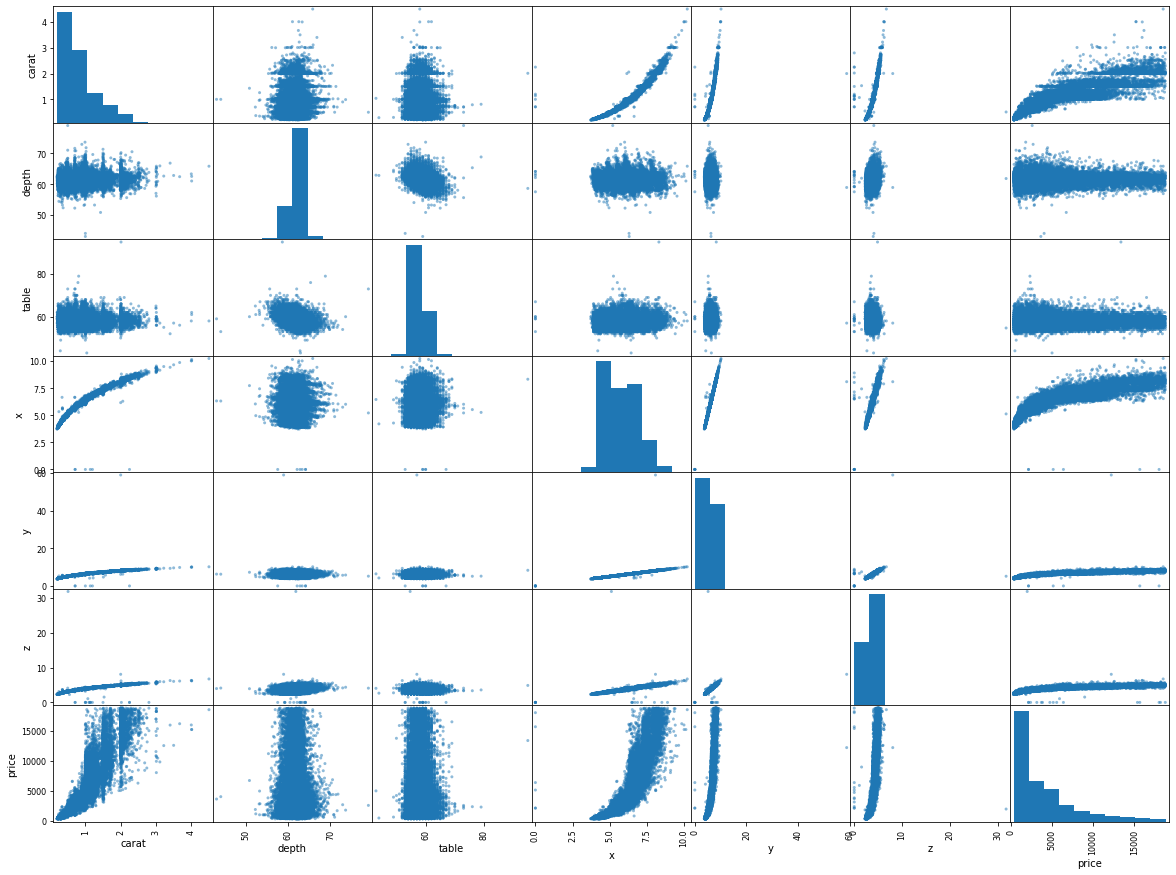

In [97]:
# Scatter plot of each feature with the target
scatter_matrix(pd.concat([X_train, y_train], axis=1), figsize=(20, 15))
plt.show()

To investigate some potential outlying values or influential points for `x`, `z`, `y`, and `table` in the training set:

In [98]:
# Container dictionary for statsmodel OLSInfluence class
diagnostics = {}

for feature in ['x', 'z', 'y', 'table']:
    # Fit Simple OLS
    results = smf.ols(formula=f'price ~ {feature}', data=pd.concat([X_train, y_train], axis=1)).fit()
    # Diagnostics (dffits)
    # Use internal dffits to avoid nobs loops for each of the feature
    diagnostics[feature] = OLSInfluence(results).dffits_internal

In [99]:
# Container for boolean indexing arrays
bool_index = {}

for key in diagnostics:
    # Find the absolute values of the dffits
    dffits_abs = np.abs(diagnostics[key][0].values)
    # Create the boolean array for the dffits that are greater than the threshold
    bool_index[key] = np.array([1 if val > diagnostics[key][1] else 0 for val in dffits_abs], dtype=bool)

In [100]:
# Reduce to combine the boolean arrays
combined_bool = reduce(lambda x, y: np.logical_or(x, y), bool_index.values())
# There is about 3176 influential points between these four features in the training set
pd.concat([X_train, y_train], axis=1).loc[combined_bool, :]

,carat,cut,color,clarity,depth,table,x,y,z,price
24251,1.51,Ideal,F,SI1,62.3,57.0,7.33,7.30,4.56,12459
24878,1.62,Premium,F,SI1,62.6,58.0,7.53,7.48,4.70,13298
27210,2.00,Ideal,F,SI2,62.9,56.0,7.94,8.01,5.02,17534
23563,1.54,Premium,G,SI1,60.5,61.0,7.47,7.44,4.51,11574
26526,1.62,Ideal,G,VS2,61.3,55.0,7.55,7.60,4.64,16183
...,...,...,...,...,...,...,...,...,...,...
24515,1.50,Very Good,G,VVS2,60.9,56.0,7.34,7.37,4.48,12798
52422,1.30,Fair,H,I1,64.4,57.0,6.93,6.86,4.44,2512
25269,1.79,Ideal,I,VS1,61.3,57.0,7.86,7.81,4.80,13908
26584,2.24,Ideal,H,SI2,61.4,56.0,8.38,8.43,5.16,16300


Conclusion: Use robust regression such as the iteratively weighted least squares with Huber weight function.

### Pipeline For Features

In [167]:
# First, generate the polynomial features
poly_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="median")),
        ('polynomial', PolynomialFeatures(degree=2, include_bias=False))
    ]
)

# Apply standardization to all numerical features
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', Normalizer())
    ]
)

# Apply one-hot encoding to categorical features
cat_pipeline = Pipeline(
    steps=[('encoder', OneHotEncoder(handle_unknown="ignore"))]
)

In [168]:
X_preprocessor = ColumnTransformer(
    transformers=[
        ("poly", poly_pipeline, ['x', 'z', 'y']),
        ("num", num_pipeline, ['carat', 'depth', 'table', 'x', 'y', 'z']),
        ("cat", cat_pipeline, ['cut', 'color', 'clarity']),
    ]
)

In [169]:
X_train_preprocessed = X_preprocessor.fit_transform(X_train)

In [197]:
X_test_preprocessed = X_preprocessor.transform(X_test)

## HuberRegressor

### Grid Search

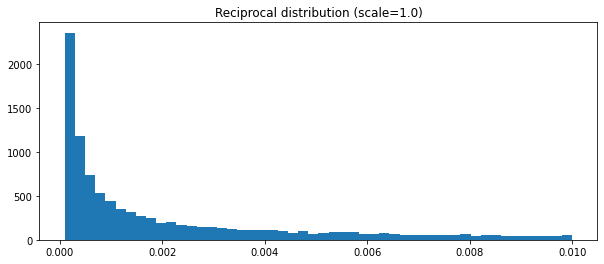

In [175]:
# Distribution for 'alpha'
reciprocal_distrib = reciprocal(0.0001, 0.01)
# Generate a random numbers
samples = reciprocal_distrib.rvs(10000, random_state=12)
# Plot
plt.figure(figsize=(10, 4))
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.show()

In [186]:
# Parameter space
param_dist = {'alpha': reciprocal(0.0001, 0.01)}

grid_search_huber = RandomizedSearchCV(
    estimator=HuberRegressor(), 
    param_distributions=param_dist, 
    # Determines the cross-validation splitting strategy
    cv=5,
    # Strategy to evaluate the performance of the cross-validated model on test set
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    random_state=12
)

In [187]:
grid_search_huber.fit(X_train_preprocessed, y_train)

RandomizedSearchCV(cv=5, estimator=HuberRegressor(), n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132956d00>,
                                        'max_iter': [7000]},
                   random_state=12, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [188]:
grid_search_huber.best_estimator_

HuberRegressor(alpha=0.006878504348963202, max_iter=7000)

In [194]:
# Clone to model for prediction
model = clone(grid_search_huber.best_estimator_)

In [196]:
# Fit
model.fit(X_train_preprocessed, y_train)

HuberRegressor(alpha=0.006878504348963202, max_iter=7000)

### HuberRegressor Performance On Training Data

In [220]:
# Predictions
y_pred_huber = model.predict(X_train_preprocessed)
# Obtain MSE and RMSE
MSE_huber, RMSE_huber = mean_squared_error(y_true=y_train, y_pred=y_pred_huber, squared=True), mean_squared_error(y_true=y_train, y_pred=y_pred_huber, squared=False)

In [221]:
f'MSE={MSE_huber} and RMSE={RMSE_huber}'

'MSE=1390752.558380383 and RMSE=1179.301724911985'

### HuberRegressor Performance On Test Data

In [222]:
# Predictions
y_pred_huber_test = model.predict(X_test_preprocessed)
# Obtain MSE and RMSE
MSE_huber_test, RMSE_huber_test = mean_squared_error(y_true=y_test, y_pred=y_pred_huber_test , squared=True), mean_squared_error(y_true=y_test, y_pred=y_pred_huber_test , squared=False)

In [223]:
f'MSE={MSE_huber_test} and RMSE={RMSE_huber_test}'

'MSE=1648799.8021686685 and RMSE=1284.0559965082007'

## AdaBoost

The AdaBoost algorithm using `HuberRegerssor` as the base estimator:

In [224]:
boosted_model = AdaBoostRegressor(
    base_estimator=grid_search_huber.best_estimator_, 
    # In case of perfect fit, the learning procedure is stopped early
    n_estimators=1000, 
    # Higher learng rate penalizes weak learners with higher error rates more and rewards stronger learners with lower error rates more
    learning_rate=1.0, 
    loss='linear', 
    random_state=12
)

In [225]:
boosted_model.fit(X_train_preprocessed, y_train)

AdaBoostRegressor(base_estimator=HuberRegressor(alpha=0.006878504348963202,
                                                max_iter=7000),
                  n_estimators=1000, random_state=12)

In [236]:
joblib.dump(boosted_model, '../models/boosting/adaboost_regressor.pkl')

['../models/boosting/adaboost.pkl']

### Boosted Model Performance On Training Data

In [228]:
# Predictions
y_pred_ada = boosted_model.predict(X_train_preprocessed)
# Obtain MSE and RMSE
MSE_ada, RMSE_ada = mean_squared_error(y_true=y_train, y_pred=y_pred_ada, squared=True), mean_squared_error(y_true=y_train, y_pred=y_pred_ada, squared=False)

In [229]:
f'MSE={MSE_ada} and RMSE={RMSE_ada}'

'MSE=1194878.9552207526 and RMSE=1093.1051894583397'

### Boosted Model Performance On Test Data

In [230]:
# Predictions
y_pred_ada_test = boosted_model.predict(X_test_preprocessed)
# Obtain MSE and RMSE
MSE_ada_test, RMSE_ada_test = mean_squared_error(y_true=y_test, y_pred=y_pred_ada_test, squared=True), mean_squared_error(y_true=y_test, y_pred=y_pred_ada_test, squared=False)

In [231]:
f'MSE={MSE_ada_test} and RMSE={RMSE_ada_test}'

'MSE=1253076.7148062792 and RMSE=1119.4090918007944'

### Using Other Loss Functions

In [249]:
# Fresh HuberRegressor estimator
fresh_huber = clone(grid_search_huber.best_estimator_)

In [251]:
# Parameter space
param_grid = {'loss': ['linear', 'square', 'exponential']}

# Base estimator
ada_base_estimator = AdaBoostRegressor(
    base_estimator=fresh_huber,
    n_estimators=1000,
    random_state=12
)

grid_search_adaboost = GridSearchCV(
    estimator=ada_base_estimator, 
    param_grid=param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [252]:
grid_search_adaboost.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 70.9min finished


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=HuberRegressor(alpha=0.006878504348963202,
                                                                       max_iter=7000),
                                         n_estimators=1000),
             n_jobs=-1,
             param_grid={'loss': ['linear', 'square', 'exponential']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [253]:
joblib.dump(grid_search_adaboost.best_estimator_, '../models/boosting/adaboost_best_regressor.pkl')

['../models/boosting/adaboost_best_regressor.pkl']

In [266]:
# The best estimator uses square loss
grid_search_adaboost.best_estimator_

AdaBoostRegressor(base_estimator=HuberRegressor(alpha=0.006878504348963202,
                                                max_iter=7000),
                  loss='square', n_estimators=1000)

### Tuned Boosted Model Performance On Training Data

In [255]:
# Predictions
y_pred_ada_tuned = grid_search_adaboost.best_estimator_.predict(X_train_preprocessed)
# Obtain MSE and RMSE
MSE_ada_tuned, RMSE_ada_tuned = mean_squared_error(y_true=y_train, y_pred=y_pred_ada_tuned, squared=True), mean_squared_error(y_true=y_train, y_pred=y_pred_ada_tuned, squared=False)

In [263]:
f'MSE={MSE_ada_tuned} and RMSE={RMSE_ada_tuned}'

'MSE=1512651.5219445415 and RMSE=1229.8989885126914'

### Tuned Boosted Model Performance On Test Data

In [265]:
# Predictions
y_pred_ada_test_tuned = grid_search_adaboost.best_estimator_.predict(X_test_preprocessed)
# Obtain MSE and RMSE
MSE_ada_test_tuned, RMSE_ada_test_tuned = mean_squared_error(y_true=y_test, y_pred=y_pred_ada_test_tuned, squared=True), mean_squared_error(y_true=y_test, y_pred=y_pred_ada_test_tuned, squared=False)

In [267]:
f'MSE={MSE_ada_test_tuned} and RMSE={RMSE_ada_test_tuned}'

'MSE=1563328.6749055297 and RMSE=1250.3314260249279'

## Performance Table

In [268]:
perf_table = (
    pd.DataFrame({
        "Performance": ["RMSE (Training Data)", "RMSE (Test Data)"],
        "HuberRegressor": [RMSE_huber, RMSE_huber_test],
        "AdaBoost With Linear Loss": [RMSE_ada, RMSE_ada_test],
        "AdaBoost With Square Loss": [RMSE_ada_tuned, RMSE_ada_test_tuned]
    })
)
perf_table

,Performance,HuberRegressor,AdaBoost With Linear Loss,AdaBoost With Square Loss
0,RMSE (Training Data),1179.301725,1093.105189,1229.898989
1,RMSE (Test Data),1284.055997,1119.409092,1250.331426
